# Data Analysis

The notebook details the process of EDA and analysis of the merged datasets.

## Content (Analysis)
- Initial Exploration of Dataset
- Exploring Feature Relationships and Correlations
- Investigating Similar Urban Centers
- MH Score vs Avg Greenness and Avg Precipitation by State

In [120]:
# set up the environment
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from sklearn.preprocessing import StandardScaler

# import modules
import map_module as map
import file_path as path

In [121]:
# load the file paths
state_data = path.state_geo_file
merged_data = path.merged_data_file
df = pd.read_csv(merged_data)

## Initial Exploration of Dataset

We begin by exploring the shapes, distributions, and frequencies of the features in our dataset through simple plots such as histograms and bar plots.

In [122]:
df.shape
#we get 40 columns instead of the 39 from the data cleaning file because exporting to and then re-importing from a csv adds an "Unnamed: 0" 
# column from the csv's index

(228, 40)

In [123]:
df.describe()

,Unnamed: 0,MH_Population,MH_Score,UC_Grouping,Urban Center Area,Latitude,Longitude,Avg Elevation,Avg Precipitation,Avg Temp,...,TCSCOE Agriculture,Particulate Matter Emissions Residential,Particulate Matter Emissions Industry,Particulate Matter Emissions Transport,Particulate Matter Emissions Agriculture,Total Concertation of Particulate Matter,% of Pop in High Green Area,% of Open Spaces,Land Use Efficiency,Max Magnitude of Heatwaves
count,228.00000,2.280000e+02,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,...,225.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,225.000000
mean,113.50000,3.751589e+05,12.990803,464.144737,375.592105,37.785570,-95.525336,292.625302,901.398919,14.346437,...,502.886180,107.402121,531.712696,71.277343,2.441286,10.449707,0.482548,54.964956,1.192774,10.835070
std,65.96211,8.899368e+05,1.964282,310.375871,758.494106,5.189609,16.933187,389.077462,427.652585,4.601192,...,865.398820,173.843394,1489.227883,165.847251,3.960416,2.280245,0.303135,21.003734,1.759177,6.835334
min,0.00000,5.946600e+04,8.700000,0.000000,26.000000,21.340678,-157.893497,3.259685,60.499999,2.990822,...,0.012980,6.284595,8.384908,1.155818,0.001450,5.765125,0.000316,17.760000,-5.099131,2.791740
25%,56.75000,9.208775e+04,11.700000,202.500000,68.500000,34.149693,-109.151526,54.113281,466.975006,10.333270,...,15.607472,24.891364,43.888854,7.426350,0.114135,9.027625,0.180279,34.585000,0.458144,6.533850
50%,113.50000,1.427565e+05,13.050000,471.500000,126.500000,38.263049,-92.065861,187.055972,984.075005,14.428775,...,131.199835,46.280523,106.128868,17.119278,0.801766,10.259220,0.556894,59.995000,0.755241,8.454350
75%,170.25000,2.773080e+05,14.300000,702.250000,294.000000,41.665072,-81.853276,301.985113,1208.487510,17.725070,...,511.853409,100.933473,307.846557,48.019920,2.837919,11.591175,0.750611,73.635000,1.418335,12.486800
max,227.00000,8.371109e+06,18.300000,1044.000000,5633.000000,61.199234,-70.292096,1923.182437,1884.924988,25.108772,...,5996.851255,1231.439826,12748.197560,1295.598590,23.907998,19.442450,0.906177,98.720000,13.731840,51.104099


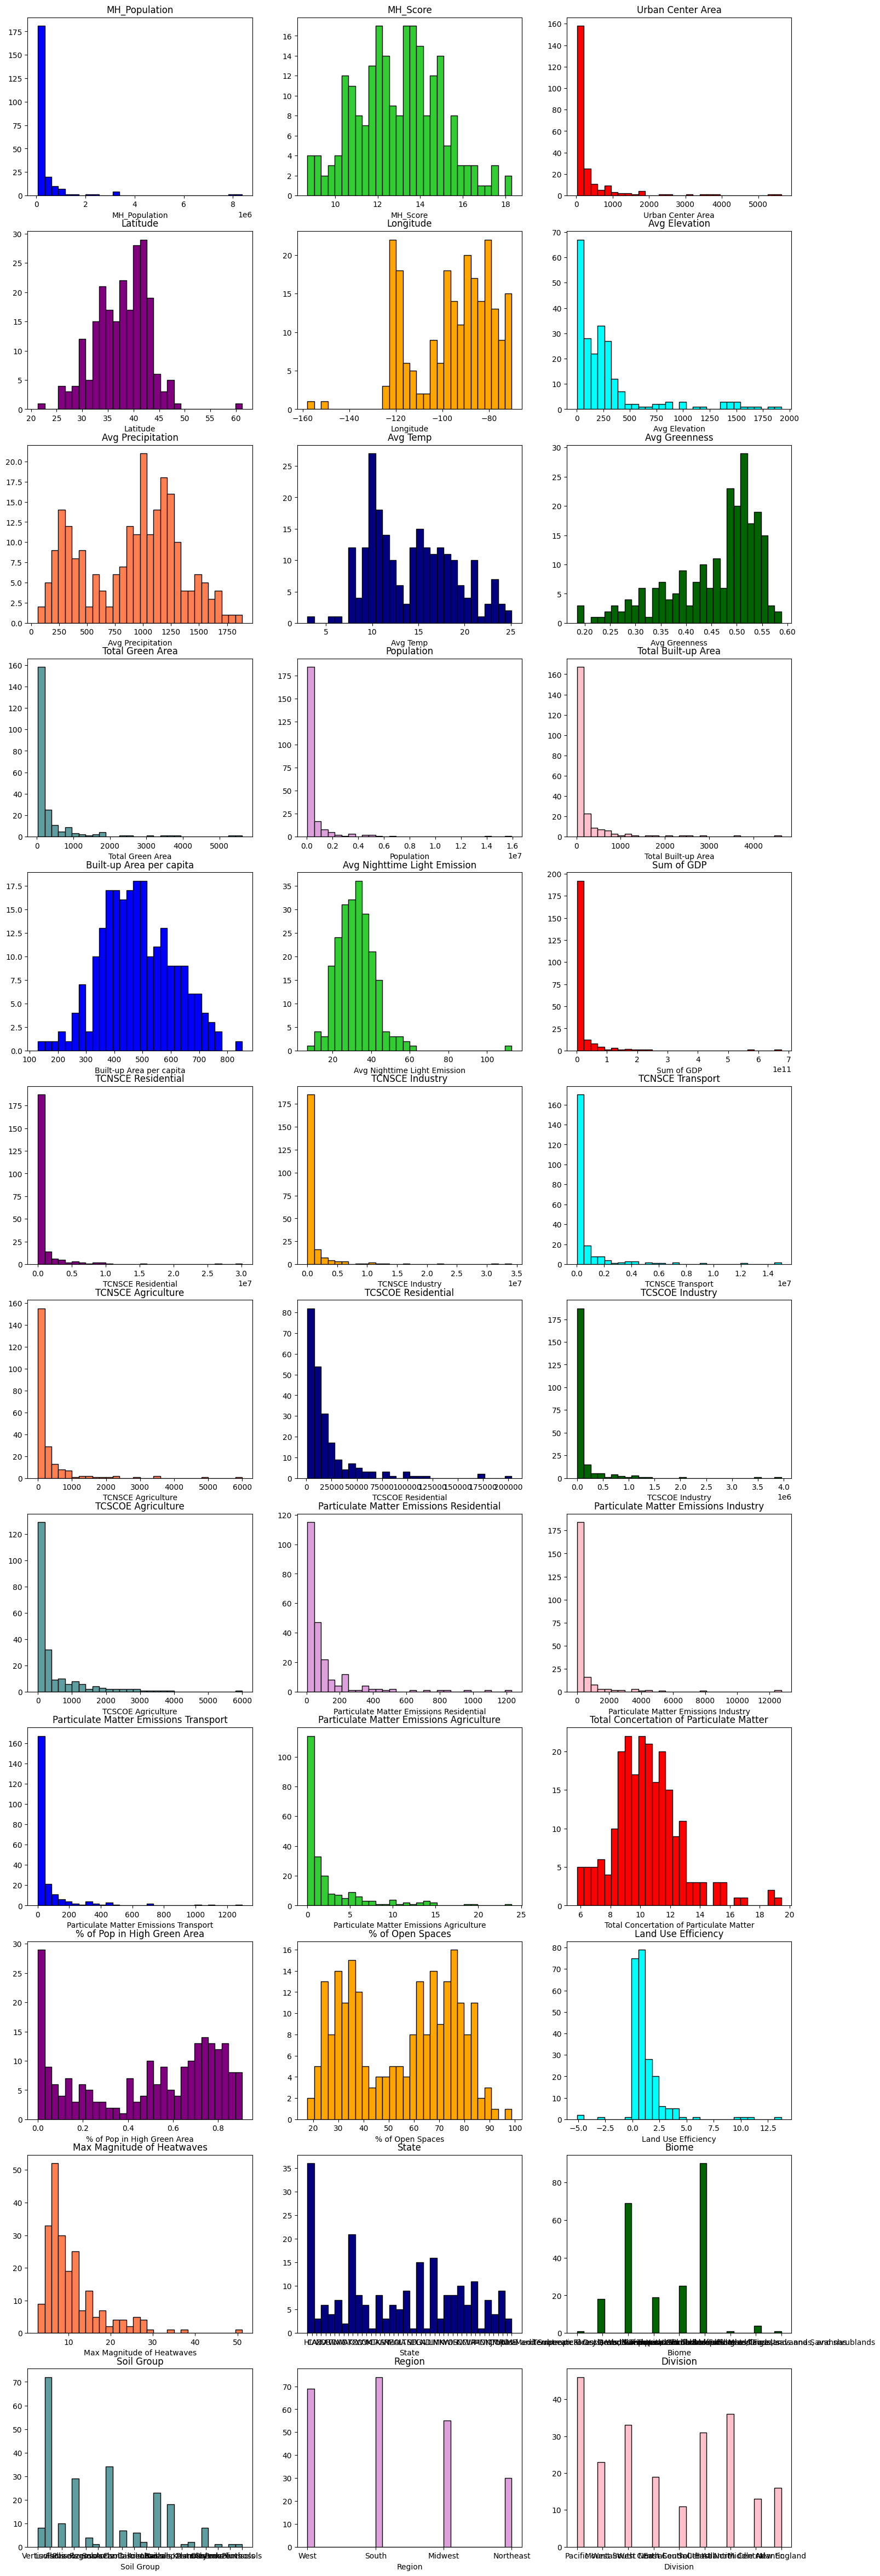

In [124]:
#create list of features to iterate through
cols = list(df.columns)
cols.remove('Unnamed: 0')
cols.remove('Urban Center')
cols.remove('UC_Grouping')
cols.remove('Cities in Urban Center_copy')

#iterate through features and create histograms showing each feature's distribution
fig, axs = plt.subplots(12, 3, figsize=(18,60))
colors = ['blue', 'limegreen', 'red', 'purple', 'orange', 'cyan', 'coral', 'navy', 'darkgreen', 'cadetblue', 'plum', 'pink', 'blue', 'limegreen', 'red', 'purple', 'orange', 'cyan', 'coral', 'navy', 'darkgreen', 'cadetblue', 'plum', 'pink', 'blue', 'limegreen', 'red', 'purple', 'orange', 'cyan', 'coral', 'navy', 'darkgreen', 'cadetblue', 'plum', 'pink']

for i, ax in enumerate(axs.flatten()):
    ax.hist(df[cols[i]], bins=30, color=colors[i], edgecolor='black')
    ax.set_title(cols[i])
    ax.set_xlabel(cols[i])

These initial histograms show that besides the Mental Health Score, the other features seem to not follow a normal distribution. This will be useful information later when we conduct statistical testing.

Now let's see what the distribution of Mental Health score is across the regions, states and Urban Centers in our dataset.

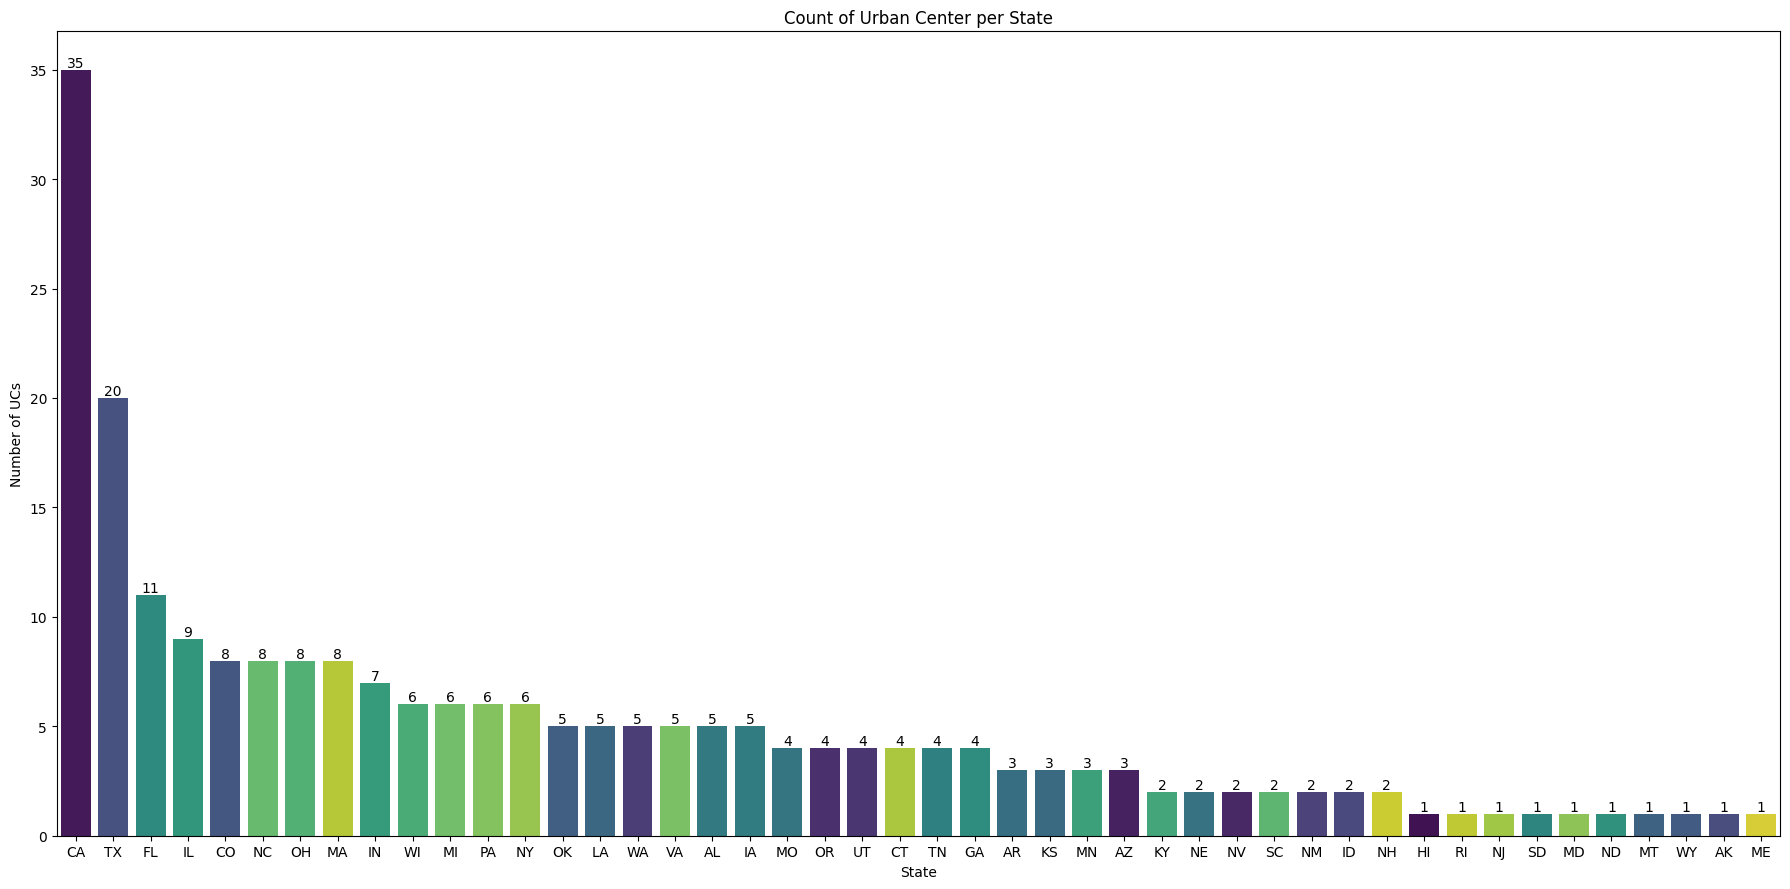

In [125]:
plt.figure(figsize=(18, 9))

state_counts = df['State'].value_counts().sort_values(ascending=False)
ax = sns.countplot(x='State', data=df, order=state_counts.index, palette='viridis', hue='State', legend=False)

plt.title('Count of Urban Center per State')
plt.xlabel('State')
plt.ylabel('Number of UCs')
    
for container in ax.containers:
    ax.bar_label(container, fmt='%d')

plt.tight_layout()
plt.show()

There are a few states like CA, TX, FL with significantly more Urban Centers in the dataset, and most of the US states had 5 or less Urban Centers in the dataset. This shows a limitation in the CDC data collected and a skew towards some states more than others. In order to compare appropriate states and UCs with each other, we need to note how many UCs the state has data for.

In [126]:
df['UCs in State'] = df['State'].map(state_counts) #raw number of how many UCs are in that State

labels = ['Scarce Data (1-3)', 'Some Data (4-5)', 'Moderate Data (6-9)',  'Data Rich (11-35)'] # States with counts between  3-1, 5- 4, 9-6, 35-11

df['State UC Data'] = pd.cut(df['UCs in State'], bins=[0, 3, 5, 9, 36], labels=labels, right=False)
#binning states by how data rich they are in terms of UC data

Let's continue with exploring the mental health scores and how they are distributed within the data

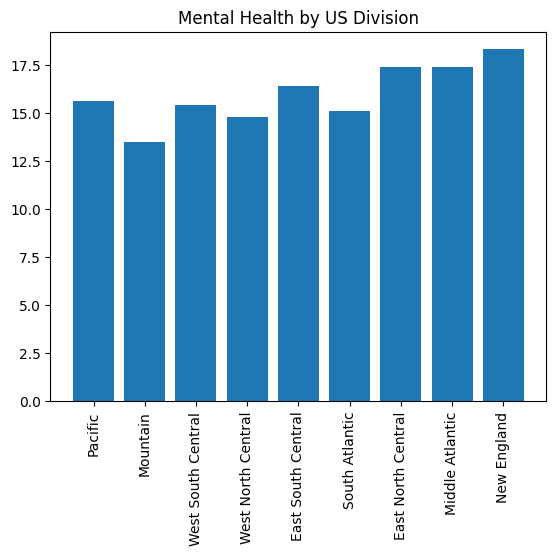

In [127]:
plt.bar(df['Division'], df['MH_Score'])
plt.xticks(rotation=90)
plt.title("Mental Health by US Division")
plt.show()

It looks to be fairly even across divisions. Let's take a look at the state level

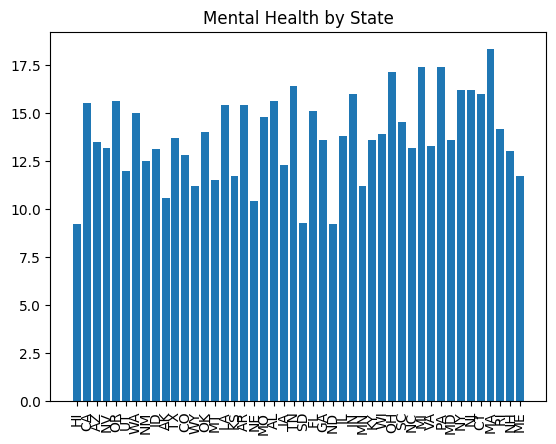

In [128]:
plt.bar(df['State'], df['MH_Score'])
plt.xticks(rotation=90)
plt.title("Mental Health by State")
plt.show()

It looks like our state with the highest mental health score (indicating worse mental health) is Massachusetts while the state with the lowest score, and thus the best mental health, is North Dakota.

Next, we will quickly examine the data at a Urban Center level. We will see the Mental Health scores for the UCs with the best mental health and worst mental health. Remember that a higher MH_Score means worse mental health prevalence in that UC.

In [129]:
top_n_highest_mh = df.sort_values(by='MH_Score', ascending=False).head(10)[['Urban Center', 'State', 'MH_Score']]

top_n_highest_mh
# New Bedford, MA / Fall River, MA / Springfield, MA/ Flint, MI/ Reading, PA     #Scores from 17.4 to 18.3, Top 10 states include MA, MI, PA, OH, TN


,Urban Center,State,MH_Score
220,New Bedford,MA,18.3
219,Fall River,MA,18.2
216,Springfield,MA,17.5
188,Flint,MI,17.4
203,Reading,PA,17.4
193,Youngstown,OH,17.1
226,Lawrence,MA,16.9
170,Dayton,OH,16.6
222,Brockton,MA,16.6
111,Memphis,TN,16.4


We notice that New Bedford, MA has the worst mental health score with 18.3. Flint, MI has a score of 17.4. The top 10 highest MH Score states include MA, MI, PA, OH, TN. 

In [130]:
top_n_lowest_mh = df.sort_values(by='MH_Score', ascending=True).head(10)[['Urban Center', 'State', 'MH_Score']]

top_n_lowest_mh

,Urban Center,State,MH_Score
184,Cary,NC,8.7
140,Roswell,GA,8.8
137,Rochester,MN,8.9
199,Washington D.C.,VA,8.9
124,Fargo,ND,9.2
0,Honolulu,HI,9.2
73,Boulder,CO,9.3
112,Sioux Falls,SD,9.3
183,Ann Arbor,MI,9.6
105,Lincoln,NE,9.6


The best Urban Centers for Mental Health scores include Cary, NC and Ann Arbor, MI ranging from 8.7 to 9.6 scores. We also notice an interesting trend which is that there is a more diverse range of states represented here in the best MH states than the worst MH states (which tended to be the same recurring states).

## Exploring Feature Relationships and Correlations

Since one of our initial objectives was to identify if there was a correlation between mental health and the greenness rating of an Urban Center, let's create a jointplot to see if there is a visually clear relationship.

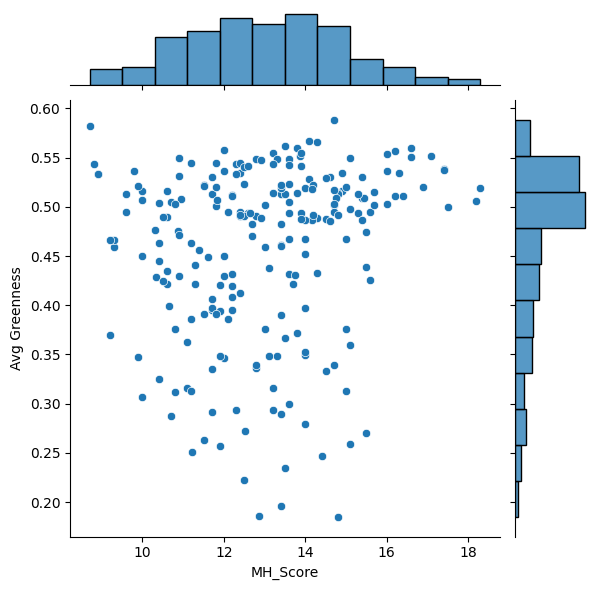

In [131]:
sns.jointplot(df, x='MH_Score', y='Avg Greenness')
plt.show()

It doesn't look like these two features are strongly correlated - greenness scores within our dataset are generally on the higher end, but corresponding Mental Health scores significantly vary. Let's move on to exploring correlations across the whole dataset and diving deeper into what we find.

Let's first split the features by categorical and numerical data so we can make correlations and statistical tests:

In [132]:
categorical_df = df.select_dtypes(include=['object', 'category'])
categorical_df.head()

,State,Urban Center,Biome,Soil Group,Cities in Urban Center_copy,Region,Division,State UC Data
0,HI,Honolulu,Tropical and Subtropical Dry Broadleaf Forests,Vertisols,Honolulu; Waipahu; Pearl City; Aiea,West,Pacific,Scarce Data (1-3)
1,CA,Santa Maria,"Mediterranean Forests, Woodlands, and Scrub",Luvisols,Santa Maria,West,Pacific,Data Rich (11-35)
2,CA,Santa Barbara,"Mediterranean Forests, Woodlands, and Scrub",Luvisols,Santa Barbara,West,Pacific,Data Rich (11-35)
3,CA,Salinas,"Mediterranean Forests, Woodlands, and Scrub",Luvisols,Salinas,West,Pacific,Data Rich (11-35)
4,CA,Oxnard,"Mediterranean Forests, Woodlands, and Scrub",Luvisols,Oxnard; Ventura,West,Pacific,Data Rich (11-35)


In [133]:
non_categorical_df = df.select_dtypes(exclude=['object', 'category'])
non_categorical_df.drop(columns=['Unnamed: 0', 'MH_Population', 'UC_Grouping'], inplace=True)
non_categorical_df.head()

,MH_Score,Urban Center Area,Latitude,Longitude,Avg Elevation,Avg Precipitation,Avg Temp,Avg Greenness,Total Green Area,Population,...,Particulate Matter Emissions Residential,Particulate Matter Emissions Industry,Particulate Matter Emissions Transport,Particulate Matter Emissions Agriculture,Total Concertation of Particulate Matter,% of Pop in High Green Area,% of Open Spaces,Land Use Efficiency,Max Magnitude of Heatwaves,UCs in State
0,9.2,185.0,21.340678,-157.893497,52.296435,741.625015,23.526622,0.369290,183.811667,512853.6667,...,40.144556,174.221274,23.536766,0.047534,5.765125,0.226415,56.41,0.074385,NaN,1
1,15.0,55.0,34.923123,-120.434372,87.128092,245.175001,14.718191,0.312846,54.450694,123181.2848,...,8.503971,35.140393,3.014213,0.047215,11.630900,0.040129,23.64,0.481144,2.79174,35
2,11.1,60.0,34.427664,-119.743693,38.298095,183.925007,15.376907,0.362785,59.576284,114753.1502,...,14.048873,30.528288,3.263458,0.013192,13.803700,0.061348,36.50,0.556762,4.25502,35
3,14.7,54.0,36.688991,-121.640831,21.308919,324.925007,15.274110,0.339631,53.886276,149784.3360,...,16.569708,65.973825,6.895041,0.059792,12.376300,0.076114,24.61,0.843804,11.39150,35
4,13.6,136.0,34.217486,-119.209132,21.899179,238.675003,17.053577,0.299903,135.224578,297806.3934,...,30.233594,118.460613,16.894830,0.072824,17.010900,0.036199,28.65,0.435584,NaN,35


There are about 30 numerical features that paint a picture for each Urban Center in terms of geographical, socioeconomic, environmental, and pollution related data. 

We decided to first explore all the numerical features to see interesting relationships, and then narrow down those relevant to Mental Health. We must first explore all correlations to see if there any confounders.

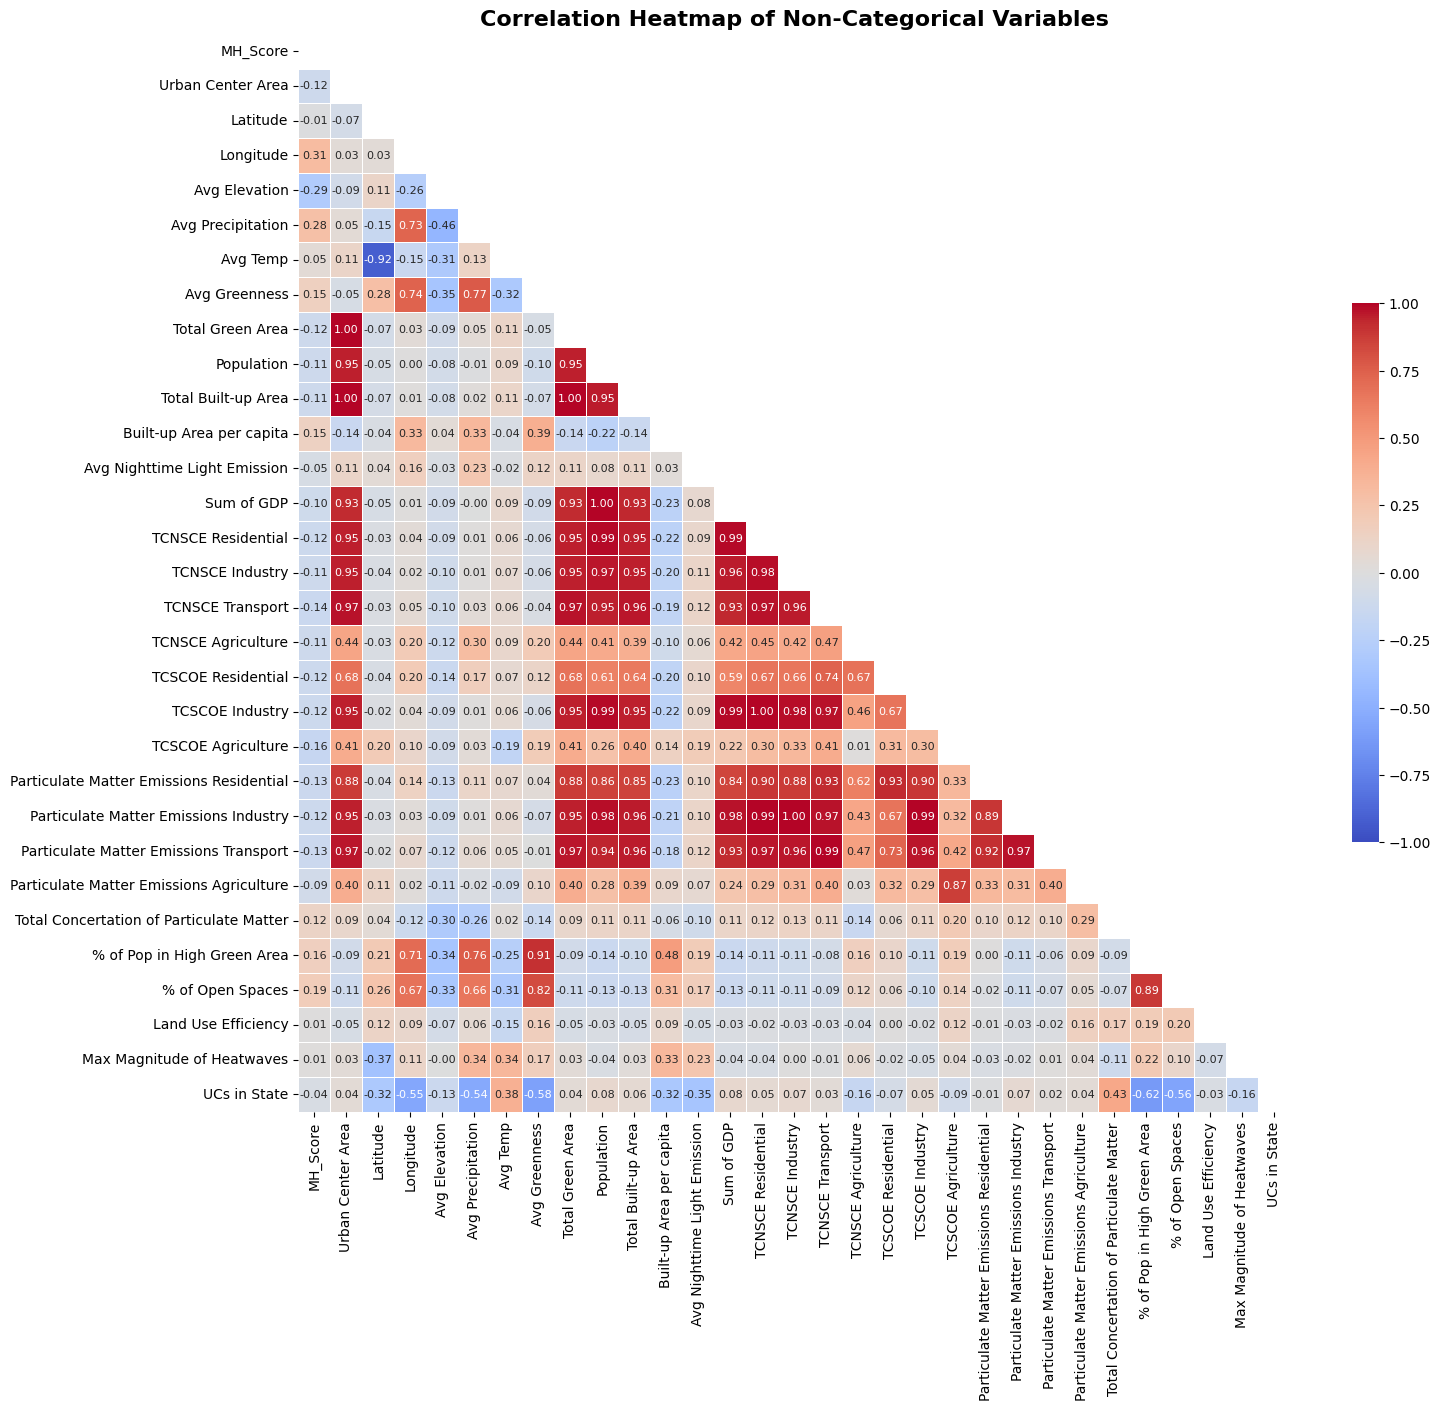

In [134]:
corr_matrix = non_categorical_df.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) #hide upper triangle which is redundant

plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix, mask = mask, annot=True,cmap='coolwarm', vmin=-1, vmax=1, 
            fmt='.2f', linewidths=.5, annot_kws={"size": 8}, cbar_kws={"shrink": 0.5})
plt.title('Correlation Heatmap of Non-Categorical Variables', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.show()

As you can see visually, there are some features that are highly correlated with each other. For example, sum of GDP has a correlation of 1 with Population! The emissions and particulate matter features are highly correlated with each other as well, which is intuitive. Interestingly, Agricultural emissions and particulate matter are only moderately correlated with the other types of emissions/PM. This makes sense since Urban Centers with agricultural emissions will be quite different from non-agricultural ones. This heatmap shows us possible confounding variables.

We will then conduct a Spearman Rank Correlation between these features with the MH_Score. We are deciding to use Spearman because the Mental Health Score tended to follow a normal distribution, and we are dealing with a mixture of normally distributed and non-normally distributed numerical variables.

In [135]:
spearcorr = non_categorical_df.corr(method='spearman')['MH_Score'].drop('MH_Score').sort_values(ascending=False)
spearcorr.head()

Longitude                      0.341468
Avg Precipitation              0.310154
Avg Greenness                  0.204443
% of Open Spaces               0.196512
% of Pop in High Green Area    0.162597
Name: MH_Score, dtype: float64

We will now create a Heatmap exploring the numerical features that have a correlation with Mental Health.

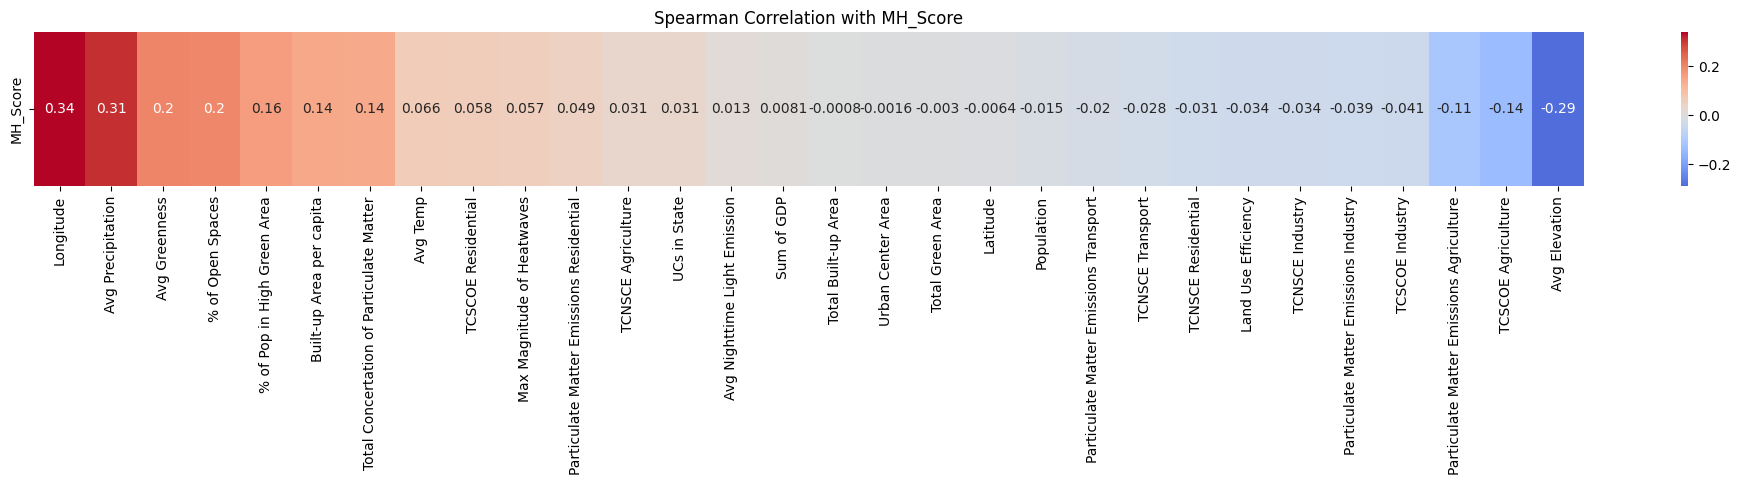

In [136]:
spcorr = spearcorr.to_frame().T

plt.figure(figsize=(25, 2))
sns.heatmap(spcorr, annot=True, cmap='coolwarm', center=0)
plt.title('Spearman Correlation with MH_Score')
plt.show()

We will then create a threshold for the Spearman Correlation so that we can notice significant features

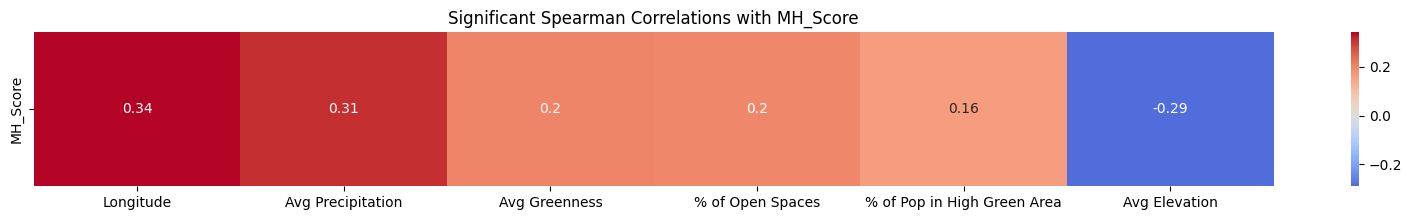

In [137]:
bthreshold = -0.15
tthreshold = 0.15

ssignicorr = spearcorr[(spearcorr < bthreshold) | (spearcorr > tthreshold)]

ssignicorrt = ssignicorr.to_frame().T

if not ssignicorrt.empty: #checking for empty correlations
    plt.figure(figsize=(20, 2))
    sns.heatmap(ssignicorrt, annot=True, cmap='coolwarm', center=0)
    plt.title('Significant Spearman Correlations with MH_Score')
    plt.show()
else:
    print("No significant correlations found")

The analysis of our data has uncovered unexpected and intriguing patterns regarding factors influencing mental health scores. Contrary to common assumptions, higher levels of average greenness appear to correlate with poorer mental health outcomes. This finding challenges the conventional wisdom that green spaces universally benefit mental wellbeing, suggesting a nuanced relationship that warrants deeper investigation. Moreover, our data indicates that total green area shows minimal to no correlation with mental health scores.

Another surprising discovery is the negative correlation observed between longitude and mental health scores. As one moves eastward, mental health scores tend to decline, hinting at geographical factors that may influence mental wellbeing. Additionally, lower average elevation is associated with better mental health outcomes, a finding that contrasts with expectations and highlights the complexity of our data.

Next, we will explore the categorical feastures in the dataset, where we are not able to run a direct Pearson or Spearman correlation on them. First, we will conduct a ANOVA test and then visualize by categorical feature. ANOVA is appropriate here since we have more than two groups and want to determine if there are statistically significant differences in the means of a continuous dependent variable (MH_Score) across these groups.

In [138]:
#By State

#ANOVA b/w numerical and categorical variable
f_statistic, p_value = f_oneway(*(df[df['State'] == state]['MH_Score'] for state in df['State'].unique()))

print("F statistic:", f_statistic)
print("P value:", p_value)

F statistic: 6.019130015672211
P value: 1.1516240928602516e-18


The small p value indicates strong evidence against the null hypothesis, suggesting that there is a significant difference in the means of MH_Score across different categories of State. Aka there is a correlation between MH_Score and State. Let's explore this visually

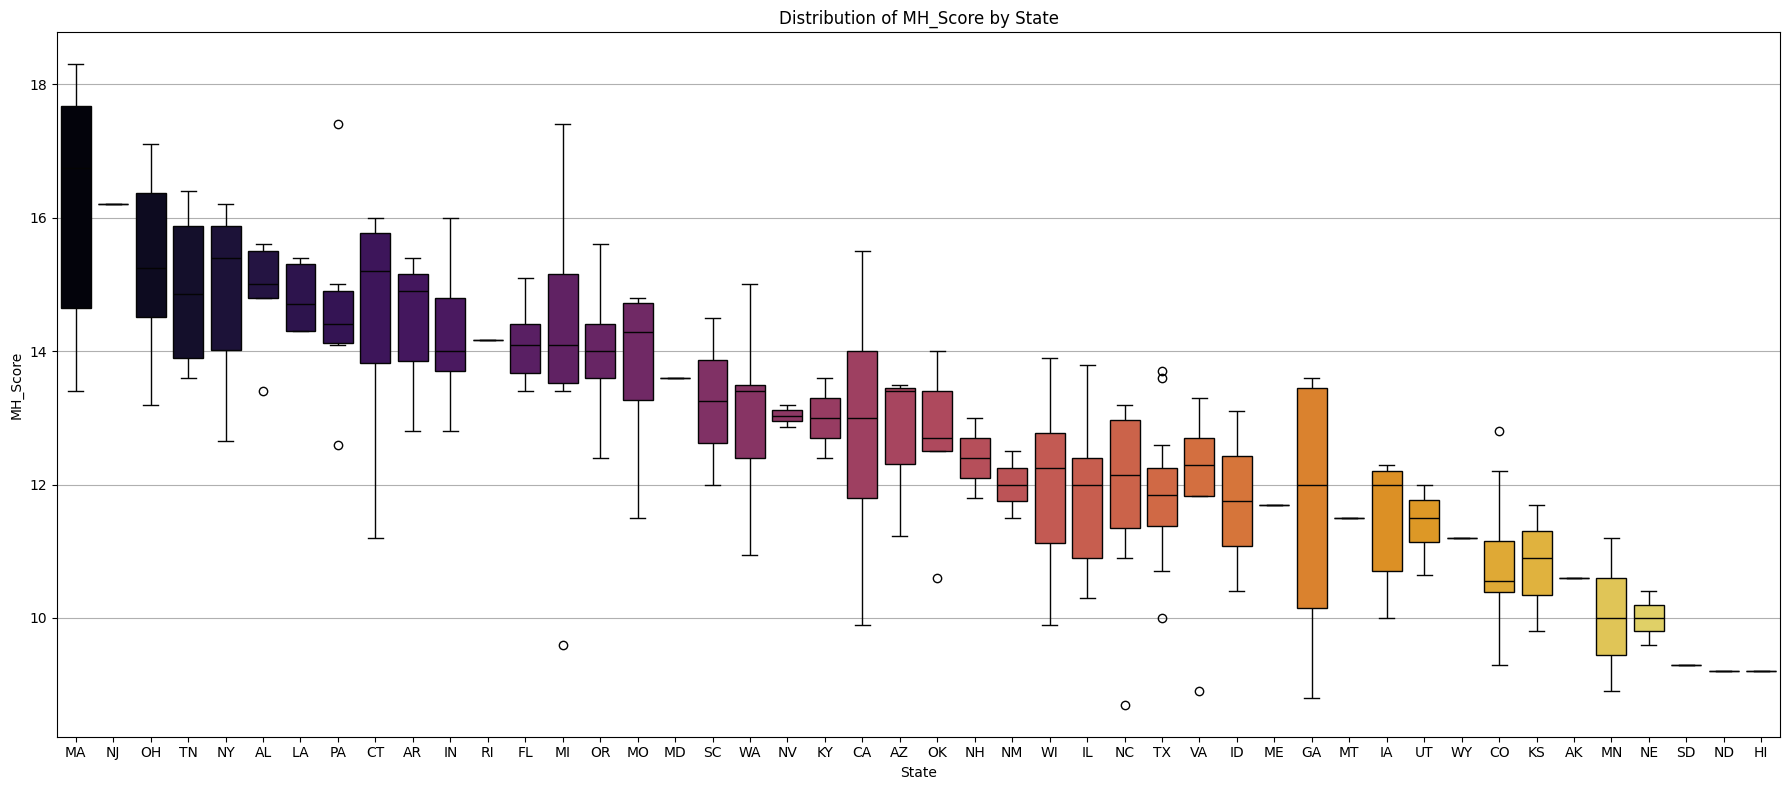

In [139]:
#Visualizing by State

mean_order = df.groupby('State')['MH_Score'].mean().sort_values(ascending=False).index

plt.figure(figsize=(18, 8))
sns.boxplot(x='State', y='MH_Score', data=df, order=mean_order, palette='inferno')

plt.title('Distribution of MH_Score by State')
plt.xlabel('State')
plt.ylabel('MH_Score')

plt.grid(axis='y')

plt.tight_layout()
plt.show()

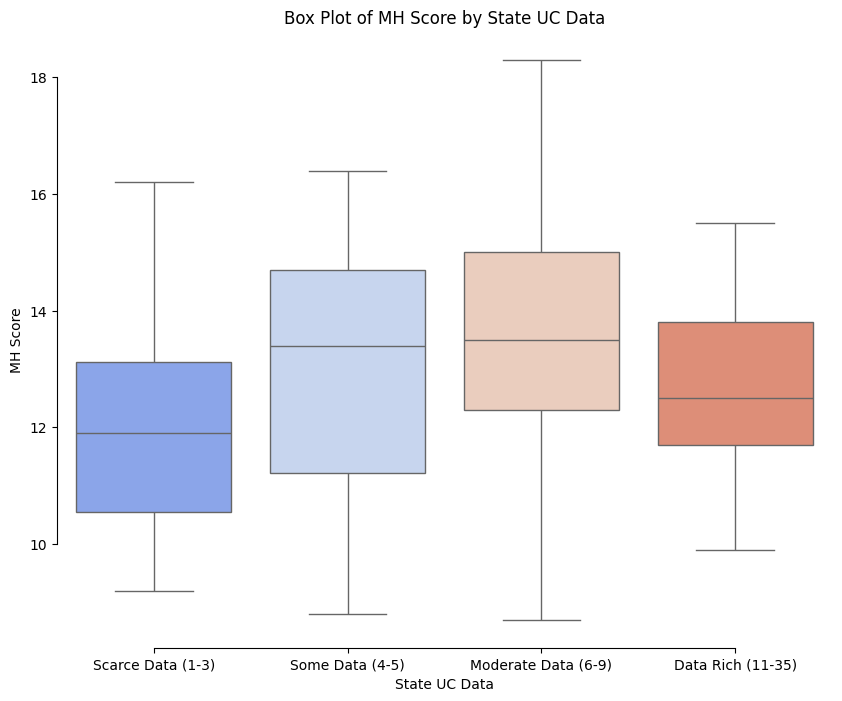

In [140]:
plt.figure(figsize=(10, 8))
sns.boxplot(x='State UC Data', y='MH_Score', data=df, order=labels, palette='coolwarm')

plt.title('Box Plot of MH Score by State UC Data')
plt.xlabel('State UC Data')
plt.ylabel('MH Score')

sns.despine(trim=True)  # Remove unnecessary spines and trim axes

plt.show()


This boxplot by the data richness of each state suggests that states with scarce UC data have better mental health scores! These states also tended to be more rural. This could be a limitation in our dataset, where more rural states have less data to truly capture the mental health status of their population.

In [141]:
#ANOVA Biome

f_statistic, p_value = f_oneway(*(df[df['Biome'] == biome]['MH_Score'] for biome in df['Biome'].unique()))

print("F statistic:", f_statistic)
print("P value:", p_value)

F statistic: 8.194477873614987
P value: 1.0919134962066466e-09


 The extremely small p value (approximately 1.09e-09) indicates strong evidence against the null hypothesis, suggesting that at least one pair of biomes significantly differs in terms of MH_Score. This finding suggests that biome type has some impact on mental health scores, needing further investigation into specific biome characteristics.

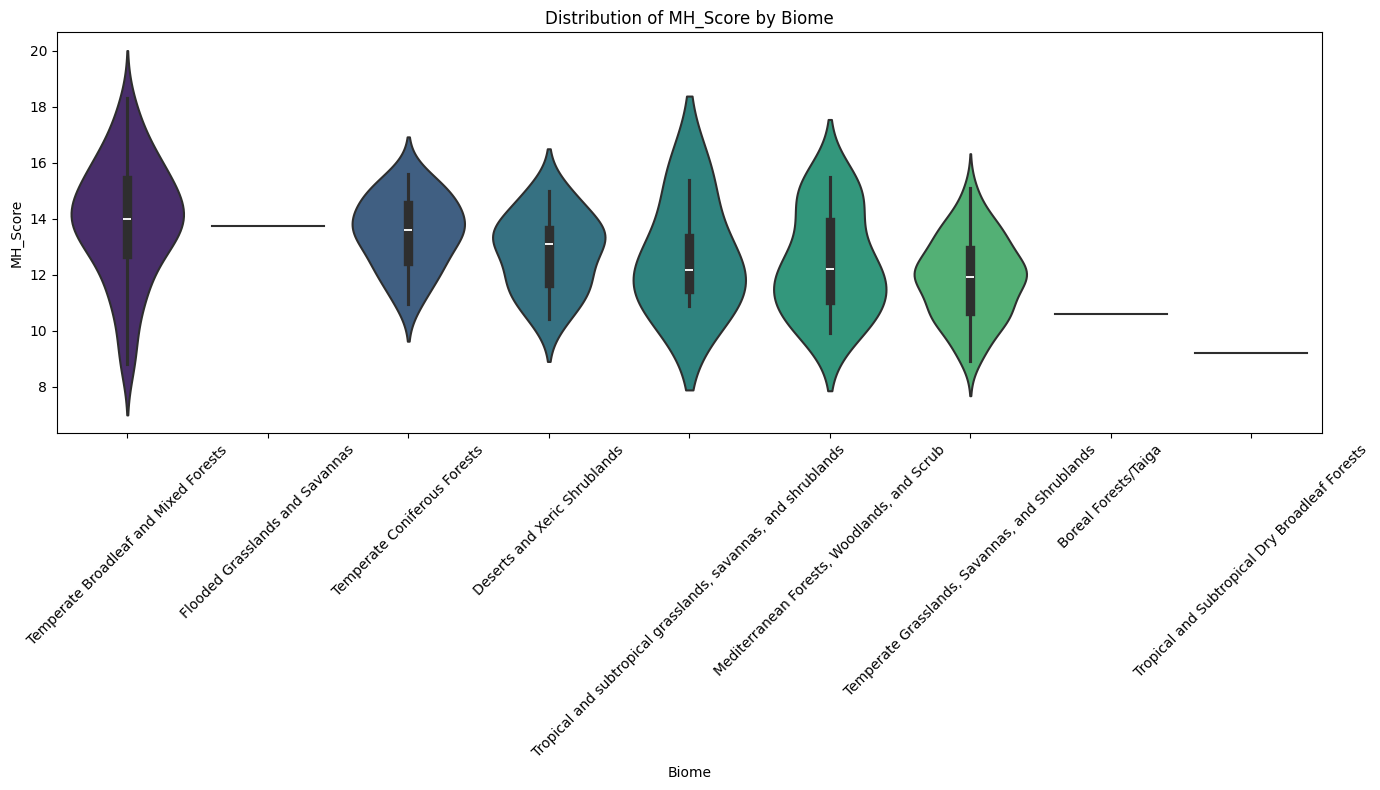

In [142]:
#By biome

mean_order = df.groupby('Biome')['MH_Score'].mean().sort_values(ascending=False).index

plt.figure(figsize=(14, 8))
sns.violinplot(x='Biome', y='MH_Score', data=df, order=mean_order, palette='viridis', linewidth=1.5)

plt.xticks(rotation=45)

plt.title('Distribution of MH_Score by Biome')
plt.xlabel('Biome')
plt.ylabel('MH_Score')

plt.tight_layout()
plt.show()

In [143]:
#ANOVA Soil

f_statistic, p_value = f_oneway(*(df[df['Soil Group'] == soil]['MH_Score'] for soil in df['Soil Group'].unique()))

print("F statistic:", f_statistic)
print("P value:", p_value)


F statistic: 3.2734732438656575
P value: 2.8667217522530002e-05


An interesting finding is the ANOVA results on Soil group! The p value of approximately 0.00003 is much smaller than the conventional significance level of 0.05, indicating strong evidence against the null hypothesis. This suggests that at least one pair of soil groups significantly differs in terms of MH_Score.

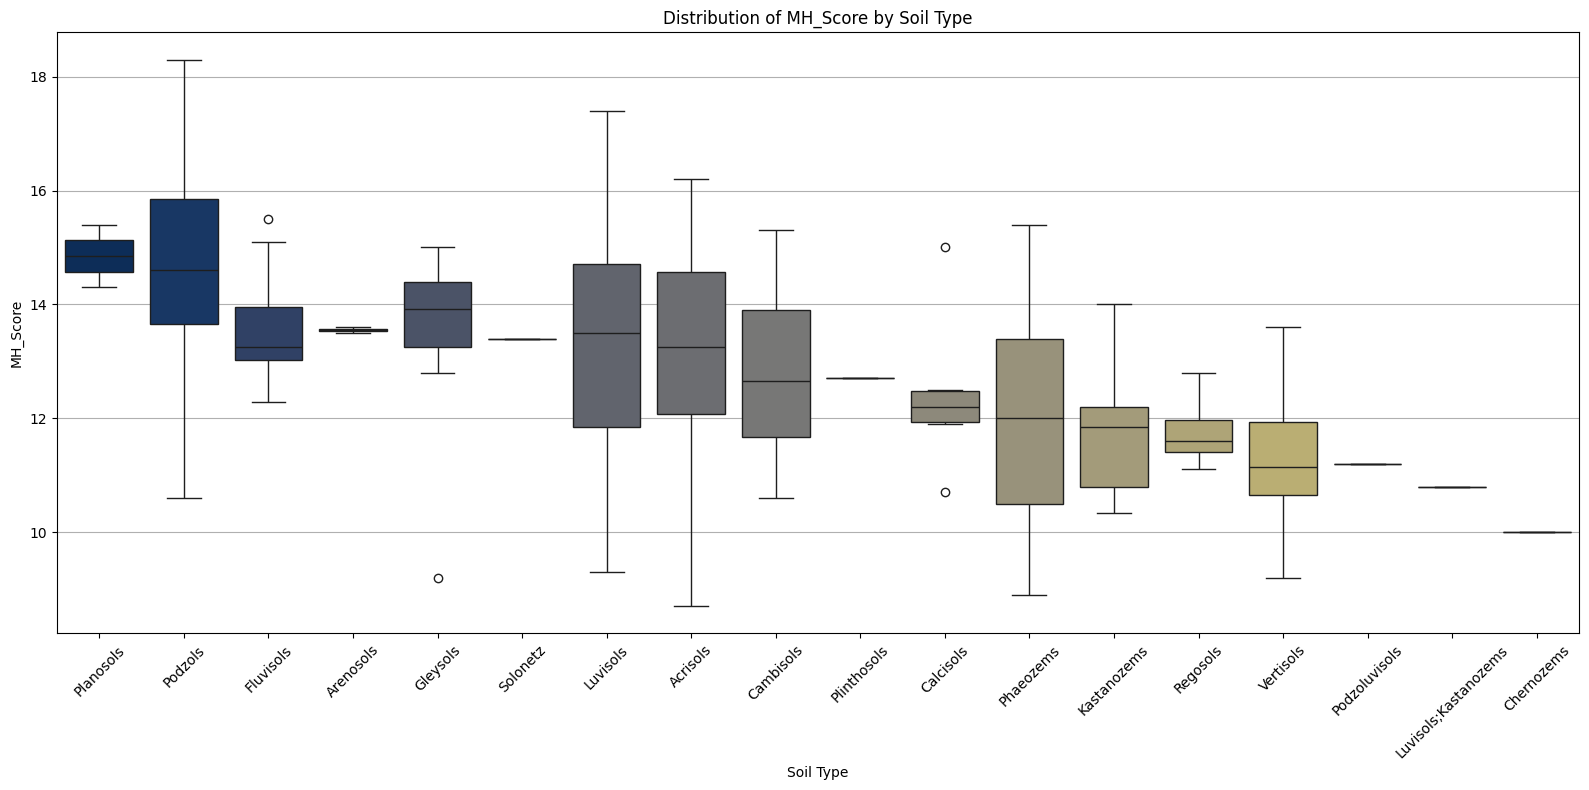

In [144]:
mean_order = df.groupby('Soil Group')['MH_Score'].mean().sort_values(ascending=False).index

plt.figure(figsize=(16, 8))
sns.boxplot(x='Soil Group', y='MH_Score', data=df, order=mean_order, palette='cividis')

plt.xticks(rotation=45)
plt.title('Distribution of MH_Score by Soil Type')
plt.xlabel('Soil Type')
plt.ylabel('MH_Score')

plt.grid(axis='y')

plt.tight_layout()
plt.show()

Now by analyzing all of these categorical and numerical features, we have found that there are several factors in an Urban Center that are worth exploration and further research. When it comes to comparing Mental Health Score between Urban Centers, we will want to minimize confounding features such as major population differences and socioeconomic status.

## Investigating Similar Urban Centers

We will now create a function to find, given an input Urban Center, the most similar Urban Center. We will then use this on cities from the Top n worst or best mental health score Urban Centers.

We will exclude features such as state, longitude, latitude, biome, Urban Center, etc as these will distort the comparison. We want to use some significant features to create a fair comparison. We decided to use 5 of the 6 most correlated features with Mental Health Score.

Note that readers and future viewers can customize this similarity function by including different features in the "signicols" list. For example, to control for Population and GDP, the user can include 'Population' and 'Sum of GDP' in the below features list and run the following cells of code to get the most similar Urban Centers with these new features.

In [145]:
signicols = ['Avg Elevation', 'Avg Precipitation', 'Avg Greenness', '% of Pop in High Green Area', '% of Open Spaces']

In [146]:
scaler = StandardScaler()
df[signicols] = scaler.fit_transform(df[signicols]) #normalize data so they can be compared
df[signicols].head()

,Avg Elevation,Avg Precipitation,Avg Greenness,% of Pop in High Green Area,% of Open Spaces
0,-0.619048,-0.374429,-0.988007,-0.846805,0.068951
1,-0.529327,-1.537855,-1.624219,-1.462687,-1.494681
2,-0.655105,-1.681394,-1.061333,-1.392535,-0.881062
3,-0.698867,-1.350962,-1.322314,-1.343719,-1.448397
4,-0.697346,-1.553088,-1.770099,-1.475682,-1.255627


The following functions allow for the comparison of Urban Centers based on their feature vectors. eucliddist quantifies the similarity between two Urban Centers by calculating the Euclidean distance between their feature vectors. A smaller Euclidean distance will indicate greater similarity in feature space. This will allow us to input a Urban Center and find the most similar centers, controlling for significant confounding features.

In [147]:
#calc euclid dist
def eucliddist(uc1, uc2):
    uc1data = df[df['Urban Center'] == uc1]
    uc2data = df[df['Urban Center'] == uc2]
    uc1feats = uc1data[signicols].values.flatten()
    uc2feats = uc2data[signicols].values.flatten()
    #print(uc1feats.shape, uc2feats.shape)

    if uc1feats.shape != uc2feats.shape:
        print(f"shapes mismatch for {uc1} and {uc2}")
        return np.inf
    return np.linalg.norm(uc1feats - uc2feats)

In [148]:
#calc similarity
def calcsimilar(inputuc):
    sims = {}
    for uc in df['Urban Center']:
    #for uc in df['UC Grouping']  #use iloc to get index to get urban center for that UC
        if uc != inputuc:
            sim = eucliddist(inputuc, uc)
            sims[uc] = sim
    return sims

In [149]:
def findclosestucs(inputuc, k=1):
    sims = calcsimilar(inputuc)
    sortedsims = sorted(sims.items(), key=lambda x: x[1])
    closestucs = sortedsims[:k]
    return closestucs

We decided to investigate the UC in our data with the highest MH score/worst mental health (New Bedford, MA), the UC with the lowest MH score/best mental health (Cary, NC), and Flint, MI because of its proximity to UMich and its tragic history regarding water and environmental features. We use the above functions to find the UCs most similar to our chosen UCs

In [150]:
inputuc = 'Flint'
closestucs = findclosestucs(inputuc, k=5)

print(f"The closest ucs to {inputuc} are:")
for uc, similarity in closestucs:
    print(f"{uc} (Similarity: {similarity})")

shapes mismatch for Flint and Portland
shapes mismatch for Flint and Lafayette
shapes mismatch for Flint and Lawrence
shapes mismatch for Flint and Springfield
shapes mismatch for Flint and Columbus
shapes mismatch for Flint and Springfield
shapes mismatch for Flint and Rochester
shapes mismatch for Flint and Bloomington
shapes mismatch for Flint and Bloomington
shapes mismatch for Flint and Lafayette
shapes mismatch for Flint and Columbus
shapes mismatch for Flint and Rochester
shapes mismatch for Flint and Springfield
shapes mismatch for Flint and Lawrence
shapes mismatch for Flint and Portland
The closest ucs to Flint are:
Lansing (Similarity: 0.2984626221664879)
Sioux City (Similarity: 0.354223090989038)
Des Moines (Similarity: 0.4628310272147309)
Rockford (Similarity: 0.49513215072157196)
Kansas City (Similarity: 0.522979765898905)


We want to compare MH scores of cities that aren't necessarily close in proximity, so we choose an urban center from the result list that is in a different state from the input city when possible.

In [151]:
inputuc = 'Cary'
closestucs = findclosestucs(inputuc, k=5)

print(f"The closest ucs to {inputuc} are:")
for uc, similarity in closestucs:
    print(f"{uc} (Similarity: {similarity})")

shapes mismatch for Cary and Portland
shapes mismatch for Cary and Lafayette
shapes mismatch for Cary and Lawrence
shapes mismatch for Cary and Springfield
shapes mismatch for Cary and Columbus
shapes mismatch for Cary and Springfield
shapes mismatch for Cary and Rochester
shapes mismatch for Cary and Bloomington
shapes mismatch for Cary and Bloomington
shapes mismatch for Cary and Lafayette
shapes mismatch for Cary and Columbus
shapes mismatch for Cary and Rochester
shapes mismatch for Cary and Springfield
shapes mismatch for Cary and Lawrence
shapes mismatch for Cary and Portland
The closest ucs to Cary are:
Raleigh (Similarity: 0.6828731728843477)
Winston-Salem (Similarity: 0.6918332775762865)
Fayetteville (Similarity: 0.7811721484128424)
Greenville (Similarity: 0.797259422695887)
Brockton (Similarity: 0.8623755018930603)


In [152]:
inputuc = 'New Bedford'
closestucs = findclosestucs(inputuc, k=5)

print(f"The closest ucs to {inputuc} are:")
for uc, similarity in closestucs:
    print(f"{uc} (Similarity: {similarity})")

shapes mismatch for New Bedford and Portland
shapes mismatch for New Bedford and Lafayette
shapes mismatch for New Bedford and Lawrence
shapes mismatch for New Bedford and Springfield
shapes mismatch for New Bedford and Columbus
shapes mismatch for New Bedford and Springfield
shapes mismatch for New Bedford and Rochester
shapes mismatch for New Bedford and Bloomington
shapes mismatch for New Bedford and Bloomington
shapes mismatch for New Bedford and Lafayette
shapes mismatch for New Bedford and Columbus
shapes mismatch for New Bedford and Rochester
shapes mismatch for New Bedford and Springfield
shapes mismatch for New Bedford and Lawrence
shapes mismatch for New Bedford and Portland
The closest ucs to New Bedford are:
Boston (Similarity: 0.25905995006870053)
Providence (Similarity: 0.3118756119135247)
Fall River (Similarity: 0.33120427966846544)
Lowell (Similarity: 0.3997810819602073)
Philadelphia (Similarity: 0.4324111045779388)


Now we plot our comparison cities: Cary vs Winston-Salem, New Bedford vs Boston, and Flint vs Des Moines.

We will compare the mental illness scores (`MH_Score`) across these six urban centers using a choropleth map organized into 2x3 subplots, each focused at the urban-center level.

It may take 30s to 1min to generate the map, but it is worth waiting :D


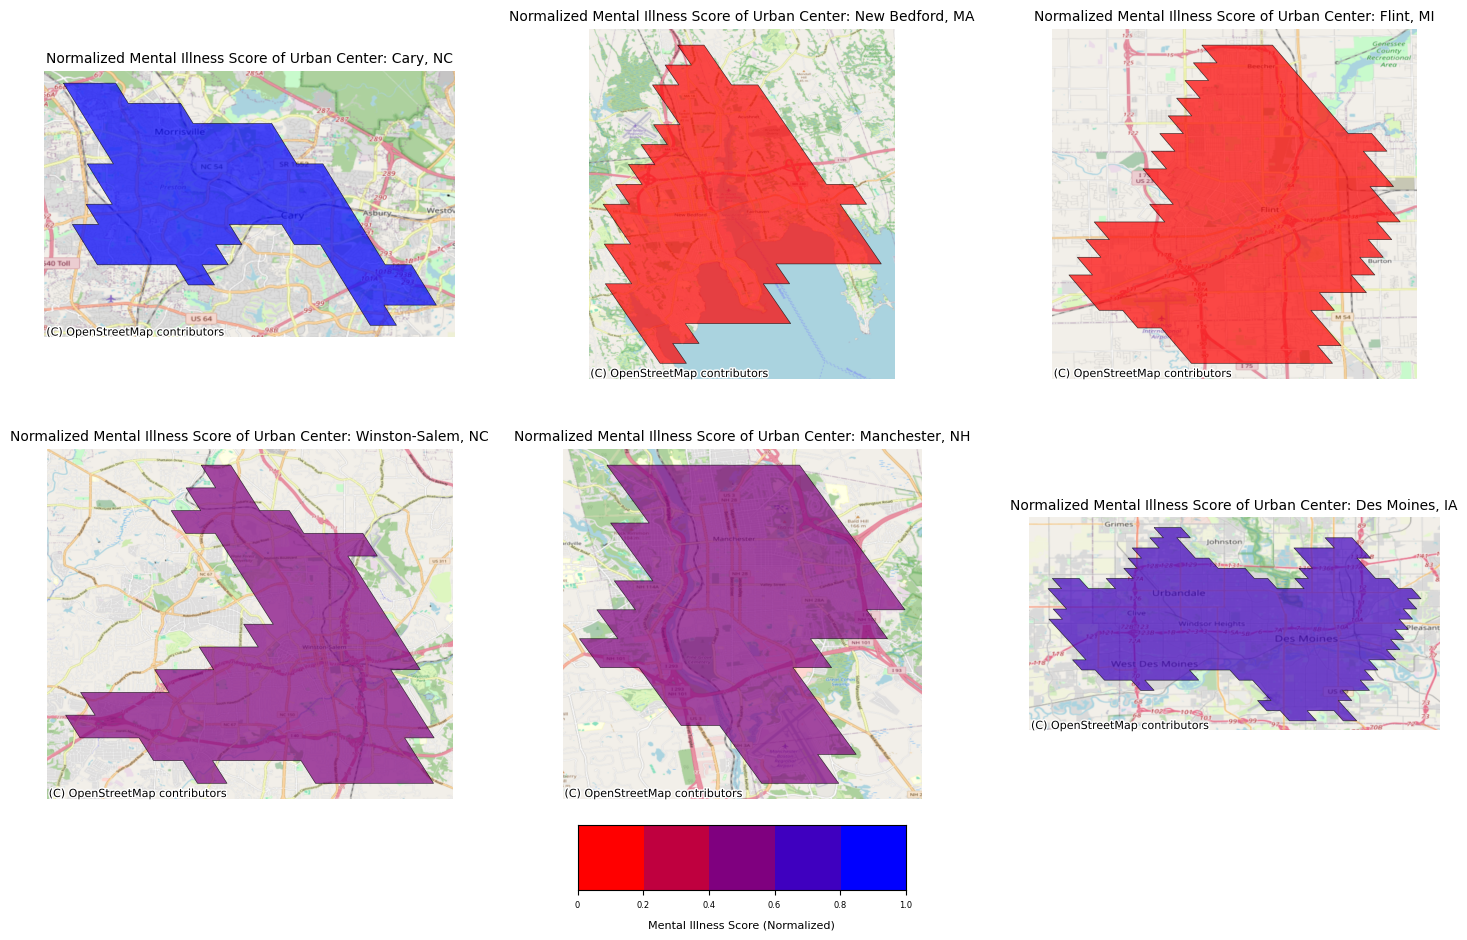

In [153]:
# import the geo file path
geo_data = path.geo_us_file

urban_center_lst=[
        "Cary",
        "New Bedford",
        "Flint",
        "Winston-Salem",
        "Manchester",
        "Des Moines",
    ]

# create the map with 6 urban centers
map.one_function_monoMap_six_urban_centers(
    geo_data,
    merged_data,
    lefton="UC_Grouping",
    righton="UC_Grouping",
    env_feature="Longitude",
    other_features=["Urban Center", "State"],
    mh_feature="MH_Score",
    percentile=np.linspace(0.2, 1, 5),
    colorlst=["#FF0000", "#0000FF"],
    mh_col="MH_Score",
    mh_color_02="mh_color",
    urban_center_lst=urban_center_lst,
    fig_row=2,
    fig_col=3,
    fig_size=(18, 10),
    alpha=0.7,
    filter_col="Urban Center",
    edgecolor="black",
    linewidth=0.5,
    plot_title_fontsize=10,
    legend_position=[-1.1, -1, 0.8, 0.8],
    tick_fontsize=6,
    label_fontsize=8,
    legend_title="Mental Illness Score (Normalized)",
)


Comparing UCs top to bottom, we see that in all three cases the Urban Centers with similar environmental features do not have similar average mental health scores. In the case of Flint, for example, the average mental health score is high (indicating poor mental health) but a similar city, Des Moines, has a much more moderate mental health score.

This further supports our finding that mental health is not necessarily strongly correlated with environmental features, as we initially expected. Further analysis into this topic is welcomed and may present additional interesting results or explanations.

## MH Score vs Avg Greenness and Avg Precipitation at State_level
As our final step of analysis in this phase of work, we will explore the relationships between:\
    1. Mental Health and Greenness\
    2. Mental Health and Precipitation\
through the use of a bi-variate geographic chloropleth map

### Avg Greenness

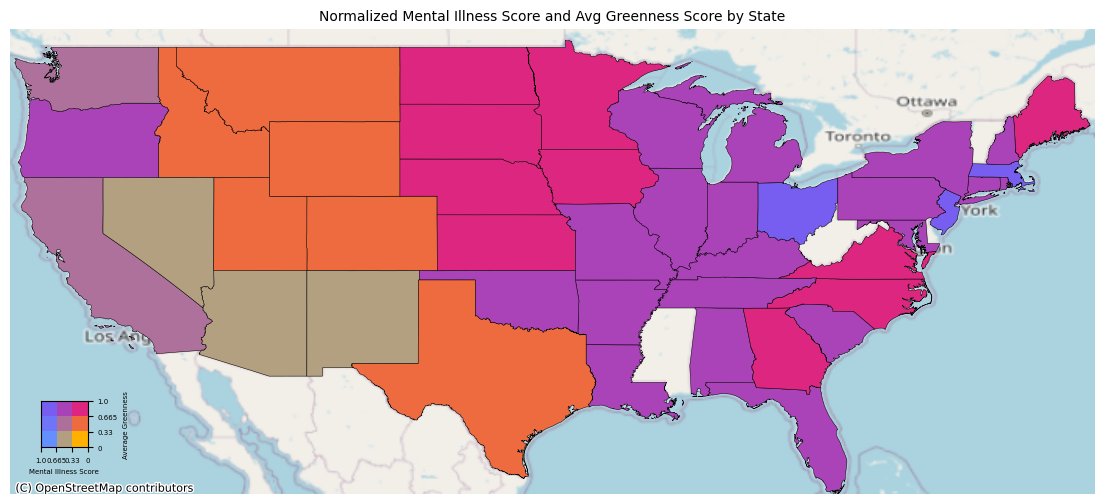

In [154]:
map.one_function_bimap_state_level(
    state_data,
    merged_data,
    env_feature="Avg Greenness",
    other_features=["State"],
    lefton="State",
    righton="STUSPS",
    mh_feature="MH_Score",
    env_color_01="c1_env",
    mh_col="MH_Score",
    mh_color_02="c2_mh",
    percentile=np.linspace(0.33, 1, 3),
    color_list=["#ffb000", "#dc267f", "#648fff", "#785ef0"],
    legend_position=[0, 0.1, 0.1, 0.1],
    tick_fontsize=5,
    label_fontsize=5,
    x_label="Mental Illness Score",
    y_label="Average Greenness",
    title_fontsize=10,
)

We can make lots of inferences from this map, one being that the average Mental Health score per state is generally on the mid-low end (indicating good mental health) while the greenness score is generally high for each state. Note that we do not have data for West Virginia, Alabama, and Vermont in our merged and cleaned dataset which leads to these states to show as white.

### Avg Precipitation 

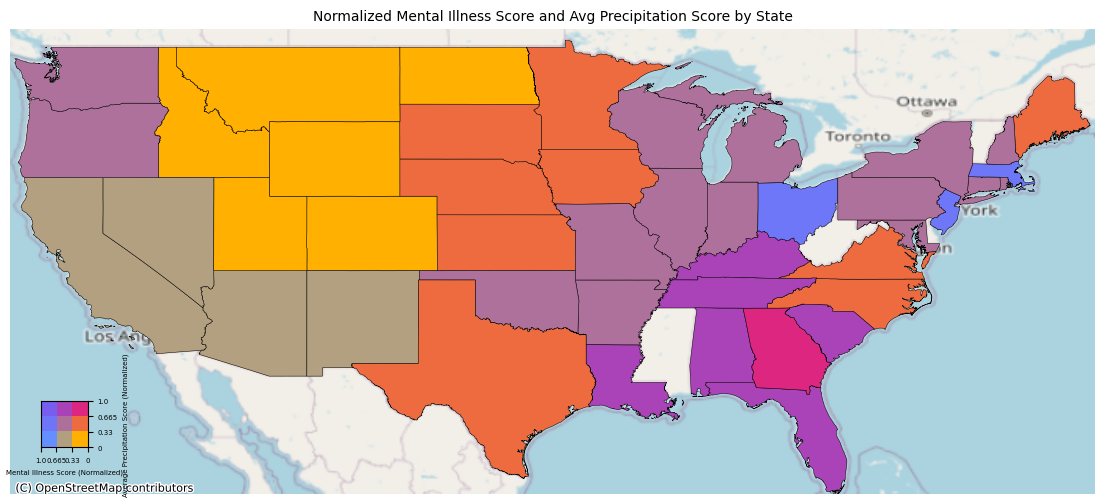

In [155]:
map.one_function_bimap_state_level(
    state_data,
    merged_data,
    env_feature="Avg Precipitation",
    other_features=["State"],
    lefton="State",
    righton="STUSPS",
    mh_feature="MH_Score",
    env_color_01="c1_env",
    mh_col="MH_Score",
    mh_color_02="c2_mh",
    percentile=np.linspace(0.33, 1, 3),
    color_list=["#ffb000", "#dc267f", "#648fff", "#785ef0"],
    legend_position=[0, 0.1, 0.1, 0.1],
    tick_fontsize=5,
    label_fontsize=5,
    x_label="Mental Illness Score (Normalized)",
    y_label="Average Precipitation Score (Normalized)",
    title_fontsize=10,
)

Once again, we can infer that the average Mental Health score for each state is on the mid-low end of the distribution, but the precipitation varies from low to high across states. We see that Southwest states that are more desert-like have a low precipitation score while the southeast tends toward the higher precipitation scores.

These maps would be a good starting point for more detailed analysis of mental health and environmental features at a regional level, an investigation we will save for a future phase of this project.